# Sto learning 


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

device = set_device(verbose=True)

cuda available


# MNIST

In [2]:
# Downloads the dataset if not found locally
from mnist import check_mnist_dataset_exists, datasampler, MNISTDataset

_ = check_mnist_dataset_exists()

nb_selected_train_data = 55000
nb_selected_test_data = 10000

train_data, train_labels, test_data, test_labels, val_data, val_labels= datasampler(
    nb_selected_train_data, nb_selected_test_data
)

trainset = MNISTDataset(train_data, train_labels, lattice_type=0)
valset = MNISTDataset(val_data, val_labels)
testset = MNISTDataset(test_data, test_labels)

## Visualise the dataset

Label: tensor(6.)
graph: DGLGraph(num_nodes=784, num_edges=3024,
         ndata_schemes={}
         edata_schemes={})
Largest eigenvalue: (2.000000000000003+0j)
Smallest eigenvalue: (1.5543122344752192e-15+0j)


/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


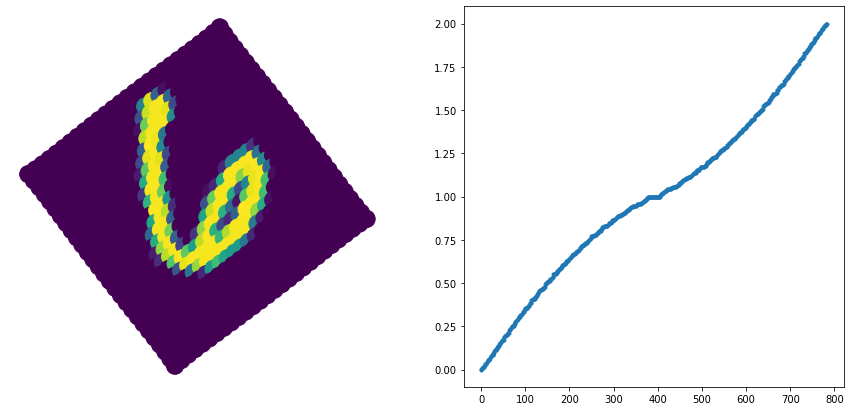

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo , s_demo= valset[random.randrange(5000)]
nx.draw_kamada_kawai(g_demo.to_networkx().to_undirected(),node_color=s_demo)
print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()



# Model definition for training

In [4]:
from model import SmallCheb, DGL_mean_Classifier_modded
# model_parameters
in_features = 1
first_conv_out = 64
second_conv_out = 128
hidden_layer_classifier = 250
k = 5
n_classes = 10

net = DGL_mean_Classifier_modded(
    in_features, 
    first_conv_out, 
    second_conv_out, 
    hidden_layer_classifier, 
    n_classes, 
    k, 
    readout = "mean"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier_modded(
  (layers): ModuleList(
    (0): Cheb_Conv(
      (fc): Linear(in_features=5, out_features=64, bias=True)
    )
    (1): Cheb_Conv(
      (fc): Linear(in_features=320, out_features=128, bias=True)
    )
    (2): Cheb_Conv(
      (fc): Linear(in_features=640, out_features=256, bias=True)
    )
    (3): Cheb_Conv(
      (fc): Linear(in_features=1280, out_features=512, bias=True)
    )
  )
  (MLP): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
from utils import load_model
#net.load_state_dict(load_model('Cheb_max_orig_cone'))

# Training pipe

In [6]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=50,
                         shuffle=True, collate_fn=collate, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=500,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=500,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=False)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

In [7]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (data, label, signal) in enumerate(data_loader):
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, 
                           signal.float().view(-1, 1).to(device),
                           (torch.ones(256)*2).to(device))
            loss = loss_func(output, label.long().to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - Acc: {} ({:.1f}%) in {:.1f}s".format(
                epoch, epoch_loss, val_loss, correct,
            100 * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [8]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (data, label, signal) in enumerate(data_loader):
            
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data,
                           signal.view(-1, 1).float(),
                           (torch.ones(500)*2).to(device))

            test_loss += loss_func(output, label.long().to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [9]:
train(net, device, train_loader, 30, loss_func,optimizer, scheduler)

Epoch 0 loss - train 1.6844 - val 1.2091 - Acc: 20530 (37.3%) in 142.7s
Epoch 1 loss - train 0.9561 - val 0.7038 - Acc: 36238 (65.9%) in 141.0s
Epoch 2 loss - train 0.7256 - val 0.5257 - Acc: 41120 (74.8%) in 141.7s
Epoch 3 loss - train 0.5886 - val 0.4630 - Acc: 44312 (80.6%) in 143.7s
Epoch 4 loss - train 0.4910 - val 0.3305 - Acc: 46293 (84.2%) in 144.5s
Epoch 5 loss - train 0.4243 - val 0.2750 - Acc: 47521 (86.4%) in 145.1s
Epoch 6 loss - train 0.3828 - val 0.2768 - Acc: 48295 (87.8%) in 146.2s
Epoch 7 loss - train 0.3503 - val 0.2293 - Acc: 48976 (89.0%) in 146.5s
Epoch 8 loss - train 0.3220 - val 0.2583 - Acc: 49367 (89.8%) in 148.0s
Epoch 9 loss - train 0.3027 - val 0.2182 - Acc: 49675 (90.3%) in 149.1s
Epoch 10 loss - train 0.2827 - val 0.1868 - Acc: 50108 (91.1%) in 149.9s
Epoch 11 loss - train 0.2685 - val 0.1767 - Acc: 50262 (91.4%) in 151.3s
Epoch 12 loss - train 0.2545 - val 0.1704 - Acc: 50566 (91.9%) in 150.7s
Epoch 13 loss - train 0.2391 - val 0.1663 - Acc: 50815 (92.4%

KeyboardInterrupt: 

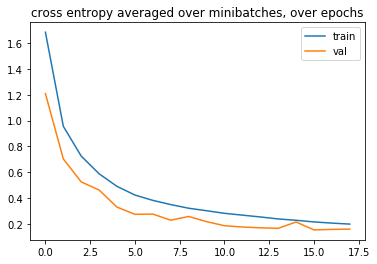

In [10]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [11]:
torch.cuda.empty_cache()

## Test Metrics

In [12]:
test(net,device,test_loader)


 Average loss per epoch: 0.1650, Accuracy: 9467/10000 (95%)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       980
         1.0       1.00      0.98      0.99      1135
         2.0       0.89      0.89      0.89      1032
         3.0       0.98      0.98      0.98      1010
         4.0       0.94      0.92      0.93       982
         5.0       0.89      0.93      0.91       892
         6.0       0.93      0.92      0.93       958
         7.0       0.91      0.97      0.94      1028
         8.0       0.99      0.98      0.99       974
         9.0       0.95      0.91      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



## Saving

In [14]:
from utils import save_model

save_model("Cheb_mean_dropout_new", net)